# Generating Ground Truth Data

### Data used to generate: Department of census & statistics poverty mapping report

This poverty mapping exercise uses the small area estimation method, which is a standard & widely used by the World Bank and international researchers. The method combines **household survey and census data** (2012 Census of Population and Housing and the 2012/13 Household Income and Expenditure Survey) to estimate household expenditure for small areas, which are necessary because household surveys alone don't provide reliable statistics below the district level.


http://www.statistics.gov.lk/Resource/en/Poverty/SpatialDistributionPovertySriLanka-2012-13.pdf



In [1]:
import pandas as pd
import geopandas as gpd
from thefuzz import process
from thefuzz import fuzz
import matplotlib.pyplot as plt

# DSD level poverty headcount index got from the department of census and statistics report
data = pd.read_csv('/lirneasia/data/sei_mapping/raw/dsd-poverty.csv')
# Sri lanka Shapefile
data_shapefile = gpd.read_file("/lirneasia/data/sei_mapping/sri_lanka_gnd_shape_files/sri_lanka_gnd.shp")
# Read census data to get population
census = pd.read_csv("/lirneasia/data/sei_mapping/raw/census_features.csv", usecols=["gnd_id", "age_total"])

### DSD level data vs GND level data

In [19]:
#DSD level
data

,dsd_id,dsd_name,district_name,headcount_index,n_poor
0,10,Dehiwala,Colombo,0.62,533
1,7,Maharagama,Colombo,1.09,"2,035"
2,8,Sri Jayawardanapura Kotte,Colombo,1.20,"1,224"
3,9,Thimbirigasyaya,Colombo,1.29,"2,766"
4,11,Rathmalana,Colombo,1.57,"1,439"
...,...,...,...,...,...
326,149,Manthai East,Mullaitivu,33.68,"2,336"
327,148,Thunukkai,Mullaitivu,34.03,"3,244"
328,150,Puthukkudiyiruppu,Mullaitivu,35.66,"8,466"
329,162,Koralai Pattu South (Kiran),Batticoloa,37.68,"9,811"


In [4]:
#GND level
#data_shapefile.set_index("code_7", inplace=True)
ground_truth = data_shapefile[['code_7', 'gnd_name', 'dsd_name', 'dist_name', 'prov_name']]
ground_truth

,code_7,gnd_name,dsd_name,dist_name,prov_name
0,8124120,Pahamunuthota,Hali Ela,Badulla,Uva
1,2121215,Asamodagamyaya,Minipe,Kandy,Central
2,2121210,Udayagala,Minipe,Kandy,Central
3,2121200,Handaganawa,Minipe,Kandy,Central
4,2121195,Diyabubula,Minipe,Kandy,Central
...,...,...,...,...,...
14017,3233110,Walakanda South,Kirinda Puhulwella,Matara,Southern
14018,3233095,Kirinda Mangin Ihala Central,Kirinda Puhulwella,Matara,Southern
14019,3233090,Kirinda Mangin Ihala South,Kirinda Puhulwella,Matara,Southern
14020,3233125,Wathukolakanda North,Kirinda Puhulwella,Matara,Southern


#### The only way to merge the two datasets is to match the DSD name in both datasets

But it leads to loose some data

In [5]:
#data_shapefile = data_shapefile.to_crs(epsg=3857)
merged = ground_truth.merge(data, left_on=ground_truth.dsd_name, right_on='dsd_name', how='inner')
merged

,dsd_name,code_7,gnd_name,dsd_name_x,dist_name,prov_name,dsd_id,dsd_name_y,district_name,headcount_index,n_poor
0,Hali Ela,8124120,Pahamunuthota,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
1,Hali Ela,8124015,Jangulla,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
2,Hali Ela,8124020,Landewela,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
3,Hali Ela,8124025,Bogoda,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
4,Hali Ela,8124030,Panakanniya,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
...,...,...,...,...,...,...,...,...,...,...,...
12726,Dickwella,3248210,Pathegama Central,Dickwella,Matara,Southern,111,Dickwella,Matara,8.52,"4,575"
12727,Dickwella,3248230,Kottagoda,Dickwella,Matara,Southern,111,Dickwella,Matara,8.52,"4,575"
12728,Dickwella,3248030,Dandeniya North,Dickwella,Matara,Southern,111,Dickwella,Matara,8.52,"4,575"
12729,Dickwella,3248225,Suduwella,Dickwella,Matara,Southern,111,Dickwella,Matara,8.52,"4,575"


Idelly there should be 14022 raws whcich is corresponding to the number of GNDs in Sri Lanka, but there are only 12731

### Usinng Fuzzy string matching technique in python

In [6]:
# Rename the misspelled columns
ground_truth["dsd_name"] = ground_truth["dsd_name"].apply(
  lambda x: process.extractOne(x, data["dsd_name"], scorer=fuzz.partial_ratio)[0]
)

merged = ground_truth.merge(data, left_on=ground_truth.dsd_name, right_on='dsd_name', how='inner')

merged


/tmp/ipykernel_30115/2280637044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth["dsd_name"] = ground_truth["dsd_name"].apply(


,dsd_name,code_7,gnd_name,dsd_name_x,dist_name,prov_name,dsd_id,dsd_name_y,district_name,headcount_index,n_poor
0,Hali Ela,8124120,Pahamunuthota,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
1,Hali Ela,8124015,Jangulla,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
2,Hali Ela,8124020,Landewela,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
3,Hali Ela,8124025,Bogoda,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
4,Hali Ela,8124030,Panakanniya,Hali Ela,Badulla,Uva,286,Hali Ela,Badulla,8.91,"7,915"
...,...,...,...,...,...,...,...,...,...,...,...
14017,Dickwella,3248210,Pathegama Central,Dickwella,Matara,Southern,111,Dickwella,Matara,8.52,"4,575"
14018,Dickwella,3248230,Kottagoda,Dickwella,Matara,Southern,111,Dickwella,Matara,8.52,"4,575"
14019,Dickwella,3248030,Dandeniya North,Dickwella,Matara,Southern,111,Dickwella,Matara,8.52,"4,575"
14020,Dickwella,3248225,Suduwella,Dickwella,Matara,Southern,111,Dickwella,Matara,8.52,"4,575"


In [ ]:
merged.to_csv("dsd_headcount_index.csv")

#### Getting absolute population from census 2012 data

In [23]:
merged = merged[['code_7', 'gnd_name', 'dsd_name', 'dist_name', 'prov_name', 'headcount_index', 'n_poor']]
#Population from census data
census = census.rename(columns={"age_total": "pop"})
census

,gnd_id,pop
0,2103005,677
1,2103010,485
2,2103015,604
3,2103020,389
4,2103025,522
...,...,...
14017,9218155,949
14018,3242080,2225
14019,3242085,3719
14020,3242110,1321


In [24]:
census = census.rename(columns={"age_total": "pop"})
census.gnd_id[census['pop'] == 0].count()

33

In [25]:
merged = merged.merge(census, left_on=merged.code_7, right_on='gnd_id', how='inner')

### Calculating GND level poverty index from DSD level index, using population as a weighted average

In [26]:
#Calculating total population for each dsd_name

total_pop_per_dsd = merged.groupby('dsd_name')['pop'].sum().reset_index()
total_pop_per_dsd.columns = ['dsd_name', 'total_pop']

merged = pd.merge(merged, total_pop_per_dsd, on='dsd_name', how='left')

merged['ground_truth'] = (merged['headcount_index'] / merged['total_pop']) * merged['pop']

#merged.drop('total_pop', axis=1, inplace=True)
merged




,code_7,gnd_name,dsd_name,dist_name,prov_name,headcount_index,n_poor,gnd_id,pop,total_pop,ground_truth
0,8124120,Pahamunuthota,Hali Ela,Badulla,Uva,8.91,"7,915",8124120,652,90571,0.064141
1,8124015,Jangulla,Hali Ela,Badulla,Uva,8.91,"7,915",8124015,1613,90571,0.158680
2,8124020,Landewela,Hali Ela,Badulla,Uva,8.91,"7,915",8124020,473,90571,0.046532
3,8124025,Bogoda,Hali Ela,Badulla,Uva,8.91,"7,915",8124025,761,90571,0.074864
4,8124030,Panakanniya,Hali Ela,Badulla,Uva,8.91,"7,915",8124030,905,90571,0.089030
...,...,...,...,...,...,...,...,...,...,...,...
14017,3248210,Pathegama Central,Dickwella,Matara,Southern,8.52,"4,575",3248210,1072,54672,0.167059
14018,3248230,Kottagoda,Dickwella,Matara,Southern,8.52,"4,575",3248230,594,54672,0.092568
14019,3248030,Dandeniya North,Dickwella,Matara,Southern,8.52,"4,575",3248030,1061,54672,0.165345
14020,3248225,Suduwella,Dickwella,Matara,Southern,8.52,"4,575",3248225,905,54672,0.141034


(dsd) headcount_index = number of poor people / total population 

(gnd)   

In [123]:
merged = merged[['code_7', 'ground_truth']]
merged.to_csv('/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/processed/dsd_to_gnd_ground_truth.csv')

### Visualizing the generated ground truth dataset

Text(0.5, 1.0, 'Ground truth map')

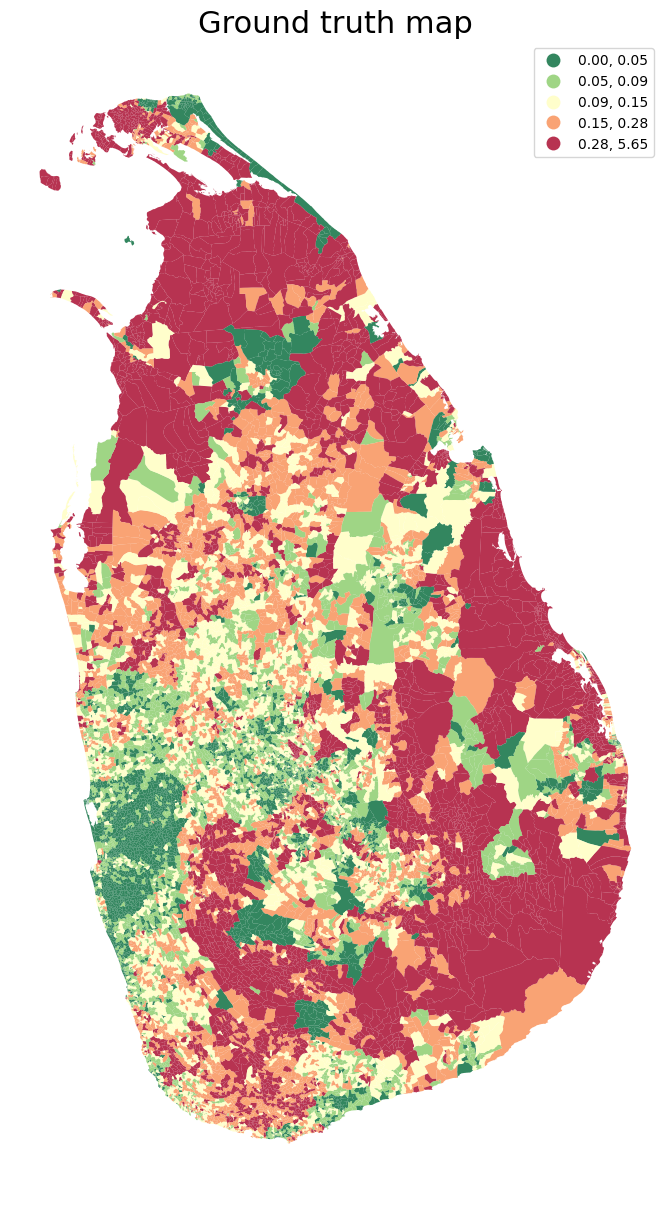

In [114]:
merged_final = data_shapefile.merge(merged, on= 'code_7', how='inner')

gdf = gpd.GeoDataFrame(merged_final, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='ground_truth',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('Ground truth map',fontsize=22)